In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from dateutil.relativedelta import relativedelta

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///data/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [9]:
# Test session connection - print first 5 ids from each table to ensure that sqlalchemy is connecting to them properlyl
for row in session.query(Measurement.id).limit(5).all():
    print(f'Measurement id: {row}')

print('----------')

for row in session.query(Station.id).limit(5).all():
    print(f'Station id: {row}')

Measurement id: (1,)
Measurement id: (2,)
Measurement id: (3,)
Measurement id: (4,)
Measurement id: (5,)
----------
Station id: (1,)
Station id: (2,)
Station id: (3,)
Station id: (4,)
Station id: (5,)


# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
max_date = session.query(func.max(Measurement.date)).all()[0][0]
print(max_date)

2017-08-23


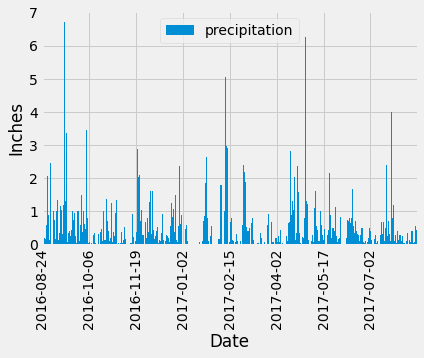

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
# first take max_date from above and convert from string into datetime object so that relative date can be calculated
# NOTE: approach taken from https://stackoverflow.com/questions/466345/converting-string-into-datetime
max_date_datetime = dt.datetime.strptime(max_date, '%Y-%m-%d')
# Then use relative delta from dateutil package to calculate date 1 year ago
# NOTE: approach taken from https://stackoverflow.com/questions/5158160/python-get-datetime-for-3-years-ago-today
max_date_minus_1yr = max_date_datetime - relativedelta(years=1)

# Perform a query to retrieve the data and precipitation scores
last_year_query = session.query(Measurement).filter(Measurement.date >= max_date_minus_1yr).\
                                             filter(Measurement.date <= max_date).statement


# Save the query results as a Pandas DataFrame and set the index to the date column
measurements_df = pd.read_sql_query(last_year_query,session.bind)

# Create new dataframe containing only columns used for analysis
measurements_plot_df = measurements_df[['date','prcp']]
measurements_plot_df = measurements_plot_df.set_index('date')

# Sort the dataframe by date
measurements_plot_sorted_df = measurements_plot_df.sort_index()


# Use Pandas Plotting with Matplotlib to plot the data
# Adjust width so that bars render appropriately
# NOTE: approach taken from https://stackoverflow.com/questions/61961123/my-bar-plot-is-not-showing-bars-for-all-the-data-values
precipitation_plot = measurements_plot_sorted_df.plot(kind='bar',width=6)

# Only show a subset of ticks on the x-axis
# NOTE: approach taken from https://stackoverflow.com/questions/6682784/reducing-number-of-plot-ticks
plt.locator_params(axis='x', nbins=8) 

plt.xlabel('Date')
plt.ylabel('Inches')
plt.legend(['precipitation'])

plt.show()

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
measurements_plot_sorted_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number stations in the dataset
total_stations = session.query(Station).count()
print(f'There are {total_stations} total stations in the dataset.')

There are 9 total stations in the dataset.


In [14]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).\
                          order_by(func.count(Measurement.station).desc()).all()
# List the results
print('Station \t Count of Measurements')

for station in active_stations:
    print(f'{station[0]} \t {station[1]}')

Station 	 Count of Measurements
USC00519281 	 2772
USC00519397 	 2724
USC00513117 	 2709
USC00519523 	 2669
USC00516128 	 2612
USC00514830 	 2202
USC00511918 	 1979
USC00517948 	 1372
USC00518838 	 511


In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = 'USC00519281'

temperature_summary = session.query(func.max(Measurement.tobs), func.min(Measurement.tobs), func.avg(Measurement.tobs)).\
                                    filter(Measurement.station == most_active_station)

# Pull out result values from query tuple output
lowest_temp = temperature_summary[0][1]
highest_temp = temperature_summary[0][0]
avg_temp = round(temperature_summary[0][2],2)

# print results
print(f'The lowest temperature for station {most_active_station} is {lowest_temp}.')
print(f'The highest temperature for station {most_active_station} is {highest_temp}.')
print(f'The average temperature for station {most_active_station} is {avg_temp}.')

The lowest temperature for station USC00519281 is 54.0.
The highest temperature for station USC00519281 is 85.0.
The average temperature for station USC00519281 is 71.66.


Text(0.5, 0, 'Temperature')

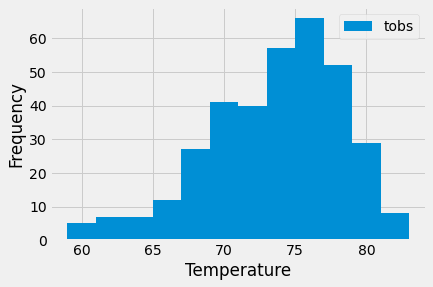

In [16]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_year_station_query = session.query(Measurement).filter(Measurement.date >= max_date_minus_1yr).\
                                                     filter(Measurement.date <= max_date).\
                                                     filter(Measurement.station == most_active_station).statement

# Read the statement into a pandas dataframe
most_active_station_df = pd.read_sql_query(last_year_station_query,session.bind)
# most_active_station_df.head()

# Plot histogram
# Pull out just temperature to pass into histogram function
most_active_station_temp_df = most_active_station_df[['tobs']]
most_active_station_temp_df.plot(kind='hist',bins=12)
plt.xlabel('Temperature')

# Close session

In [17]:
# Close Session
session.close()